# Predicting Soccer Injuries with Machine Learning
## Ensemble Models

Jennifer Lawless    
DASC 9311: Data Science Project    
November 10, 2025

This notebook use ensemble methods to find the best model to predict injuries in soccer. The methods include a Stacking Ensemble, Voting Classifier, and Bayesian Model Averaging, and the approaches combine predictions from the five previously trained baseline and advanced models (Logistic Regression, Random Forest, XGBoost, LightGBM, and SVM).

## Imports and Display Settings

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.calibration import cross_val_predict
import numpy as np
import pandas as pd
import warnings
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [27]:
# Suppress warnings and set display styles:
warnings.filterwarnings('ignore')

# Set display options:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Reproducibility

In [28]:
# Define seeds for reproducibility:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

## Data Loading

In [35]:
# Load the dataset:
df = pd.read_csv('data_prepped.csv')
df.head()

,Injury_Next_Season,Agility_Score,Balance_Test_Score,Fitness_Score,Hamstring_Flexibility,Knee_Strength_Score,Low_Fitness,Nutrition_Quality_Score,Previous_Injury_Count,Reaction_Time_ms,Sleep_Hours_Per_Night,Sprint_Speed_10m_s,Stress_Level_Score,Stress_Sleep_Ratio,Warmup_Routine_Adherence,Wellness_Score
0,0,-0.087649,1.069297,0.491996,-0.005236,0.379259,0,0.760997,-0.411816,1.560205,1.037465,-0.227881,-0.650428,-0.899441,1,1.127931
1,0,1.843613,0.500648,1.111952,0.502136,-0.346362,0,0.716401,0.475002,0.050595,1.979228,-0.468019,-0.409281,-0.982990,1,1.340729
2,1,-0.939707,-0.058566,-0.519264,-0.475015,0.319748,0,-1.020030,0.475002,0.876025,-0.237389,-0.667398,-0.955724,-0.741810,0,-0.023700
3,0,0.586842,0.543868,0.619538,-0.780880,1.183688,0,1.657432,-0.411816,-1.026915,0.333441,0.831162,-0.219940,-0.361847,1,1.022099
4,1,0.996011,-0.104356,0.394975,-0.369953,0.275898,0,-0.301841,0.475002,-0.909176,-0.870460,-1.725425,-0.145343,0.189340,0,-0.399246


In [37]:
# Define engineered features:
engineered_features = [
    'Fitness_Score', 'Wellness_Score', 'Workload_Recovery_Ratio',
    'Stress_Sleep_Ratio', 'Low_Fitness'
]

# Separate features and target variable:
X_full = df.drop(columns=['Injury_Next_Season'])
y = df['Injury_Next_Season']

# Define the three feature subsets:
full_features = X_full.columns.tolist()
raw_features  = [c for c in X_full.columns if c not in engineered_features]
xgb_features  = [c for c in X_full.columns if c != 'Balance_Test_Score']

# Output the feature sets:
print("Feature sets prepared:")
print(f"Full features: {len(full_features)} features")
print(f"Raw features: {len(raw_features)} features")
print(f"XGBoost features: {len(xgb_features)} features")

Feature sets prepared:
Full features: 15 features
Raw features: 11 features
XGBoost features: 14 features


## Pre-Trained Model Loading

In [38]:
# Define a function to load the models:
def load_model(path, name):
    try:
        model = joblib.load(path)
        print(f"{name} loaded")
        return model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    except:
        print(f"Could not load {name}")
        return None

lr_base   = load_model('logistic_regression_model.joblib', 'Logistic Regression')
rf_base   = load_model('random_forest_model.joblib',      'Random Forest')
xgb_base  = load_model('xgboost_model.joblib',           'XGBoost')
lgb_model = load_model('lightgbm_model.joblib',          'LightGBM')
svm_model = load_model('svm_model.joblib',               'SVM')

Logistic Regression loaded
Random Forest loaded
XGBoost loaded
LightGBM loaded
SVM loaded


## Pipeline Creation

In [39]:
# Column transformers for each feature subset:
ct_full = make_column_transformer(('passthrough', full_features), remainder='drop')
ct_raw  = make_column_transformer(('passthrough', raw_features),  remainder='drop')
ct_xgb  = make_column_transformer(('passthrough', xgb_features),  remainder='drop')

# Pipeline for each base model:
base_estimators = [
    ('lr',   make_pipeline(ct_full, lr_base)),
    ('rf',   make_pipeline(ct_raw,  rf_base)),
    ('xgb',  make_pipeline(ct_xgb,  xgb_base)),
    ('lgb',  make_pipeline(ct_full, lgb_model)),
    ('svm',  make_pipeline(ct_raw,  svm_model))
]

## Evaluation Settings

In [41]:
# Define evaluation settings:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [42]:
# Define a helper function for printing results:
def print_cv_results(cv_results, model_name):
    print(f"\n{model_name} Results\n")
    metrics_summary = {k: np.mean(cv_results[f'test_{k}']) for k in scoring.keys()}
    print("Cross-Validation Results (mean across folds):")
    for metric, score in metrics_summary.items():
        print(f"{metric.capitalize():9}: {score:.3f}")

## Model 6: Voting Classifier (Soft Voting)

### Model Development and Evaluation

In [ ]:
# Create voting classifier with soft voting (probability-based):
voting_soft = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

# Evaluate the voting classifier using cross-validation:
cv_results_voting_soft = cross_validate(voting_soft, X_full, y, cv=cv, scoring=scoring,
                                       return_estimator=True, n_jobs=-1)

# Print the cross-validation results:
print_cv_results(cv_results_voting_soft, "Model 6: Voting Classifier (Soft Voting)")


Model 6: Voting Classifier (Soft Voting) Results

Cross-Validation Results (mean across folds):
Accuracy : 0.950
Precision: 0.953
Recall   : 0.948
F1       : 0.950
Roc_auc  : 0.990


In [ ]:
# Save the best model:
best_model_voting_soft = cv_results_voting_soft['estimator'][0]
joblib.dump(best_model_voting_soft, 'voting_soft_model.joblib')
print("\nModel saved as 'voting_soft_model.joblib'")


Model saved as 'voting_soft_model.joblib'


### Mean Performance Metrics Across Folds

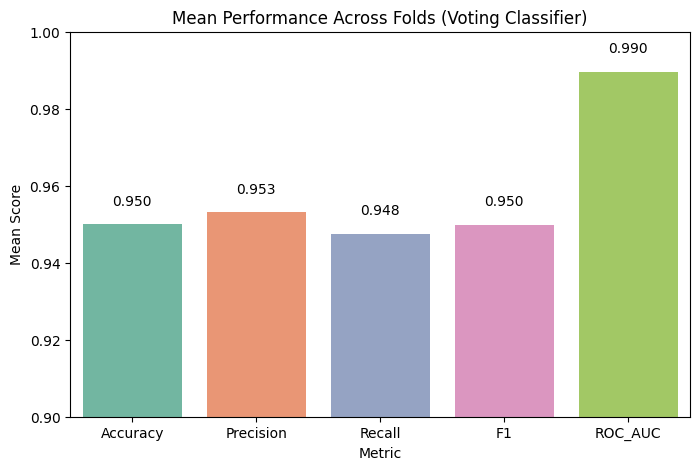

In [ ]:
# Collect metrics from CV results:
metrics_df_voting_soft = pd.DataFrame({
    'Accuracy': cv_results_voting_soft['test_accuracy'],
    'Precision': cv_results_voting_soft['test_precision'],
    'Recall': cv_results_voting_soft['test_recall'],
    'F1': cv_results_voting_soft['test_f1'],
    'ROC_AUC': cv_results_voting_soft['test_roc_auc']
})

# Create a bar chart of mean scores:
mean_scores = metrics_df_voting_soft.mean().reset_index()
mean_scores.columns = ['Metric', 'Mean Score']
plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (Voting Classifier)")
plt.ylim(0.9, 1.0)
for i, row in mean_scores.iterrows():
    plt.text(i, row['Mean Score']+0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

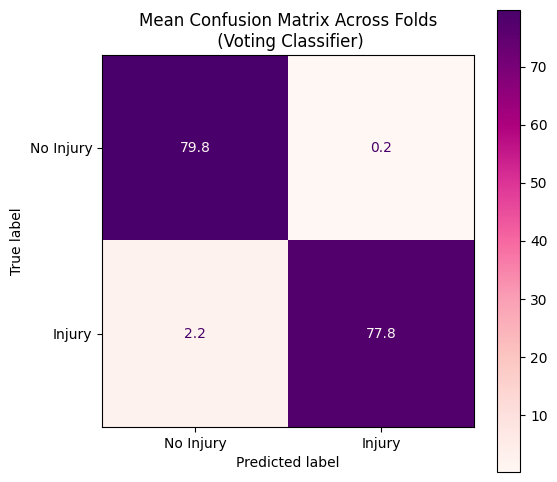

Mean Confusion Matrix:


,No Injury,Injury
No Injury,79.8,0.2
Injury,2.2,77.8


In [ ]:
# Collect confusion matrices across outer folds
cms = []
for i, estimator in enumerate(cv_results_voting_soft['estimator']):
    X_test = X_full.iloc[cv.split(X_full, y).__next__()[1]]  # lazy but works
    y_test = y.iloc[cv.split(X_full, y).__next__()[1]]
    y_pred = estimator.predict(X_full.iloc[cv.split(X_full, y).__next__()[1]])
    cms.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds
mean_cm = np.mean(cms, axis=0)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm,
                              display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='RdPu', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Folds\n (Voting Classifier)")
plt.show()

# Output the confusion matrix DataFrame
mean_cm_df = pd.DataFrame(mean_cm, index=['No Injury', 'Injury'], 
                            columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df)

### ROC Curves

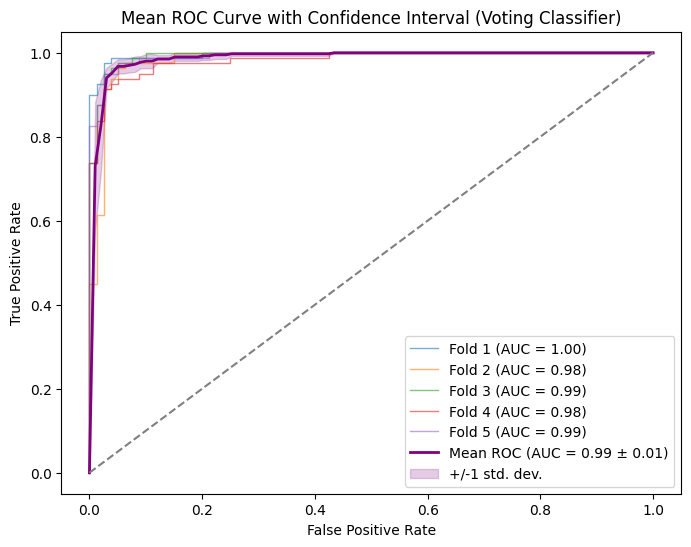

In [ ]:
# Plot ROC curves for each fold and the mean ROC curve:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8,6))
for i, estimator in enumerate(cv_results_voting_soft['estimator']):
    train_idx, test_idx = list(cv.split(X_full, y))[i]
    X_test, y_test = X_full.iloc[test_idx], y.iloc[test_idx]
    probas = estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='purple',
         label=f'Mean ROC (AUC = {mean_auc:.2f} +/- {std_auc:.2f})', lw=2)
plt.fill_between(mean_fpr, np.minimum(mean_tpr + np.std(tprs, axis=0), 1),
                 np.maximum(mean_tpr - np.std(tprs, axis=0), 0),
                 color='purple', alpha=0.2, label='+/-1 std. dev.')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Mean ROC Curve with Confidence Interval (Voting Classifier)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Model 7: Stacking Ensemble

### Model Development and Evaluation

In [50]:
# Create a stacking ensemble classifier:
stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    cv=3,
    n_jobs=-1
)

# Evaluate the stacking ensemble classifier using cross-validation:
cv_results_stacking = cross_validate(stacking, X_full, y, cv=cv, scoring=scoring,
                                    return_estimator=True, n_jobs=-1)

# Print the cross-validation results:
print_cv_results(cv_results_stacking, "Model 7: Stacking Ensemble")


Model 7: Stacking Ensemble Results

Cross-Validation Results (mean across folds):
Accuracy : 0.951
Precision: 0.951
Recall   : 0.953
F1       : 0.951
Roc_auc  : 0.990


In [51]:
# Save the best model:
best_model_stacking = cv_results_stacking['estimator'][0]
joblib.dump(best_model_stacking, 'stacking_model.joblib')
print("\nModel saved as 'stacking_model.joblib'")


Model saved as 'stacking_model.joblib'


### Mean Performance Metrics Across Folds

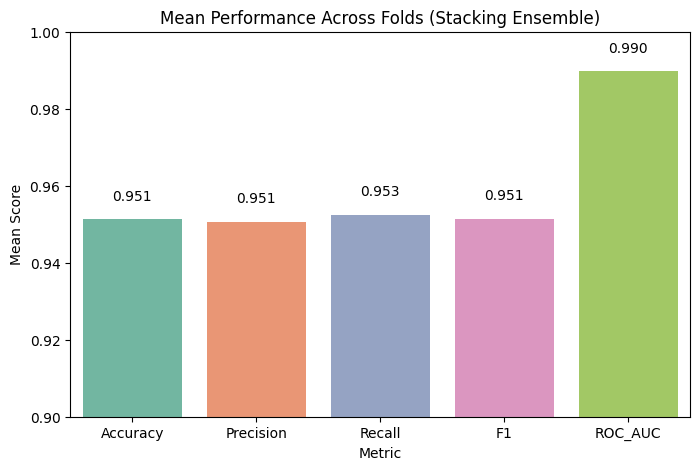

In [52]:
# Collect metrics from CV results:
metrics_df_stacking = pd.DataFrame({
    'Accuracy': cv_results_stacking['test_accuracy'],
    'Precision': cv_results_stacking['test_precision'],
    'Recall': cv_results_stacking['test_recall'],
    'F1': cv_results_stacking['test_f1'],
    'ROC_AUC': cv_results_stacking['test_roc_auc']
})

# Create a bar chart of mean scores:
mean_scores = metrics_df_stacking.mean().reset_index()
mean_scores.columns = ['Metric', 'Mean Score']
plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (Stacking Ensemble)")
plt.ylim(0.9, 1.0)
for i, row in mean_scores.iterrows():
    plt.text(i, row['Mean Score']+0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

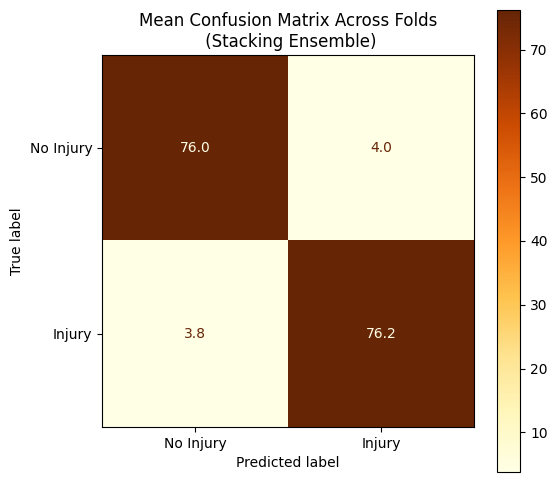

Mean Confusion Matrix:


,No Injury,Injury
No Injury,76.0,4.0
Injury,3.8,76.2


In [69]:
# Confusion matrix:
cms = []
for i, (train_idx, test_idx) in enumerate(cv.split(X_full, y)):
    est = cv_results_stacking['estimator'][i]
    y_pred = est.predict(X_full.iloc[test_idx])
    cms.append(confusion_matrix(y.iloc[test_idx], y_pred))
mean_cm = np.mean(cms, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='YlOrBr', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Folds\n (Stacking Ensemble)")
plt.show()

# Output the confusion matrix DataFrame:
mean_cm_df = pd.DataFrame(mean_cm, index=['No Injury', 'Injury'], 
                            columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df)

### ROC Curves

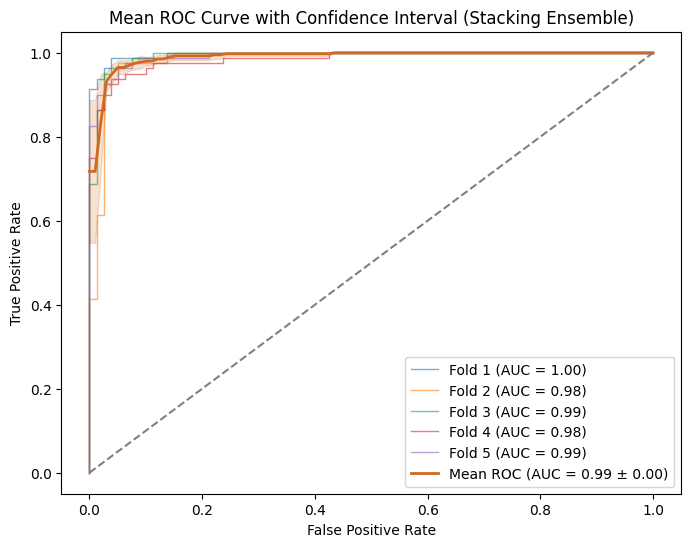

In [54]:
# Plot ROC curves for each fold and the mean ROC curve:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8,6))
for i, (train_idx, test_idx) in enumerate(cv.split(X_full, y)):
    est = cv_results_stacking['estimator'][i]
    prob = est.predict_proba(X_full.iloc[test_idx])[:,1]
    fpr, tpr, _ = roc_curve(y.iloc[test_idx], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    tprs.append(np.interp(mean_fpr, fpr, tpr))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='chocolate',
         label=f'Mean ROC (AUC = {mean_auc:.2f} +/- {np.std(aucs):.2f})', lw=2)
plt.fill_between(mean_fpr, np.minimum(mean_tpr + np.std(tprs, axis=0),1),
                 np.maximum(mean_tpr - np.std(tprs, axis=0),0),
                 color='chocolate', alpha=0.2)
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Mean ROC Curve with Confidence Interval (Stacking Ensemble)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Model 8: Bayesian Model Averaging

### Model Development and Evaluation

In [62]:
# Compute out-of-fold log-loss for each base model (used only for weighting):
logloss_scores = {}
oof_predictions = {}

for name, estimator in base_estimators:
    y_oof_pred = cross_val_predict(
        estimator, X_full, y,
        cv=cv, method='predict_proba', n_jobs=-1
    )[:, 1]
    y_oof_pred = np.clip(y_oof_pred, 1e-15, 1 - 1e-15)
    fold_logloss = log_loss(y, y_oof_pred)
    logloss_scores[name] = fold_logloss
    oof_predictions[name] = y_oof_pred

# Convert to approximate log model evidence and softmax:
log_evidence = -np.array([
    logloss_scores['lr'], logloss_scores['rf'],
    logloss_scores['xgb'], logloss_scores['lgb'],
    logloss_scores['svm']
])
shifted = log_evidence - log_evidence.max()
bma_weights = np.exp(shifted) / np.exp(shifted).sum()

print("Final Bayesian Model Averaging Weights (from negative log-loss):")
for name, w in zip(['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM'], bma_weights):
    print(f"{name:<20}: {w:.4f}")

# Define the final BMA class:
class BayesianModelAveraging(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, weights):
        self.estimators = estimators
        self.weights = weights

    def fit(self, X, y):
        self.models_ = [clone(est).fit(X, y) for _, est in self.estimators]
        return self

    def predict_proba(self, X):
        probas = np.array([model.predict_proba(X)[:, 1] for model in self.models_])
        weighted_proba = np.average(probas, axis=0, weights=self.weights)
        return np.vstack([1 - weighted_proba, weighted_proba]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Evaluate BMA with the full metrics:
bma_clf = BayesianModelAveraging(base_estimators, weights=bma_weights)
cv_results_bma = cross_validate(
    bma_clf, X_full, y,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# Print the cross-validation results:
print_cv_results(cv_results_bma, "Model 8: Bayesian Model Averaging")

Final Bayesian Model Averaging Weights (from negative log-loss):
Logistic Regression : 0.2063
Random Forest       : 0.1857
XGBoost             : 0.2025
LightGBM            : 0.2019
SVM                 : 0.2035

Model 8: Bayesian Model Averaging Results

Cross-Validation Results (mean across folds):
Accuracy : 0.950
Precision: 0.953
Recall   : 0.948
F1       : 0.950
Roc_auc  : nan


In [64]:
# Save the best model:
best_idx = np.argmax(cv_results_bma['test_roc_auc'])
best_bma_model = cv_results_bma['estimator'][best_idx]
joblib.dump(best_bma_model, 'bma_model.joblib')
print("\nModel saved as 'bma_model.joblib'")


Model saved as 'bma_model.joblib'


### Mean Performance Metrics Across Folds

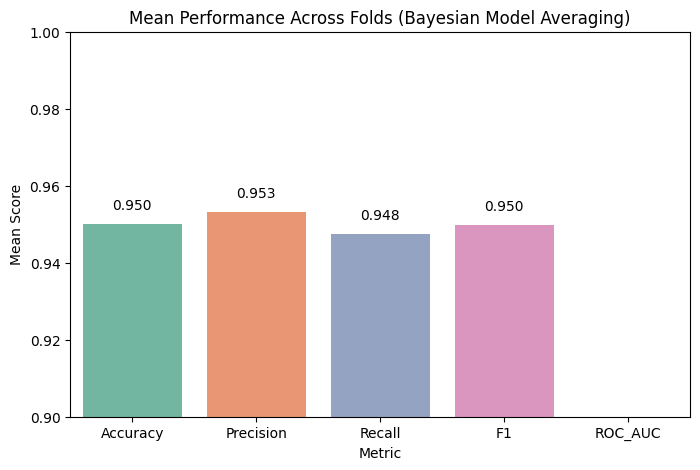

In [ ]:
# Collect metrics from CV results:
metrics_df_bma = pd.DataFrame({
    'Accuracy': cv_results_bma['test_accuracy'],
    'Precision': cv_results_bma['test_precision'],
    'Recall': cv_results_bma['test_recall'],
    'F1': cv_results_bma['test_f1'],
    'ROC_AUC': cv_results_bma['test_roc_auc']
})

mean_scores = metrics_df_bma.mean().reset_index()
mean_scores.columns = ['Metric', 'Mean Score']

# Create a bar chart of mean scores:
plt.figure(figsize=(8, 5))
bars = sns.barplot(data=mean_scores, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (Bayesian Model Averaging)")
plt.ylim(0.90, 1.0)
for i, row in mean_scores.iterrows():
    plt.text(i, row['Mean Score'] + 0.003, f"{row['Mean Score']:.3f}", 
             ha='center', va='bottom')
plt.show()

### Confusion Matrix

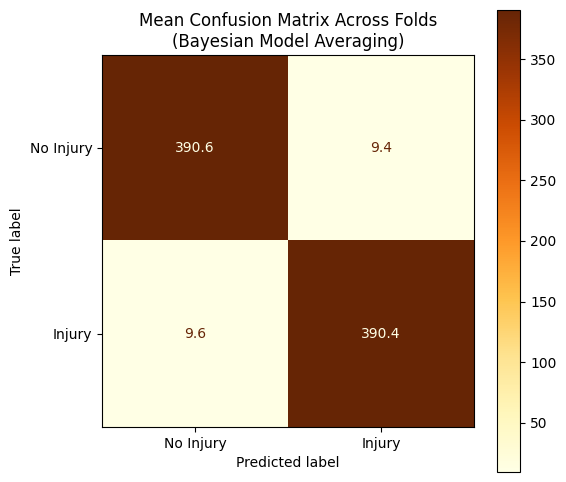

Mean Confusion Matrix:


,No Injury,Injury
No Injury,390.6,9.4
Injury,9.6,390.4


In [70]:
# Calculate mean confusion matrix:
cms = []
for estimator in cv_results_bma['estimator']:
    y_pred = estimator.predict(X_full)
    cms.append(confusion_matrix(y, y_pred))

mean_cm = np.mean(cms, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm.round(1), display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='YlOrBr', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Folds\n(Bayesian Model Averaging)")
plt.show()

# Output the confusion matrix DataFrame:
mean_cm_df = pd.DataFrame(mean_cm, index=['No Injury', 'Injury'], columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df)

### ROC Curves

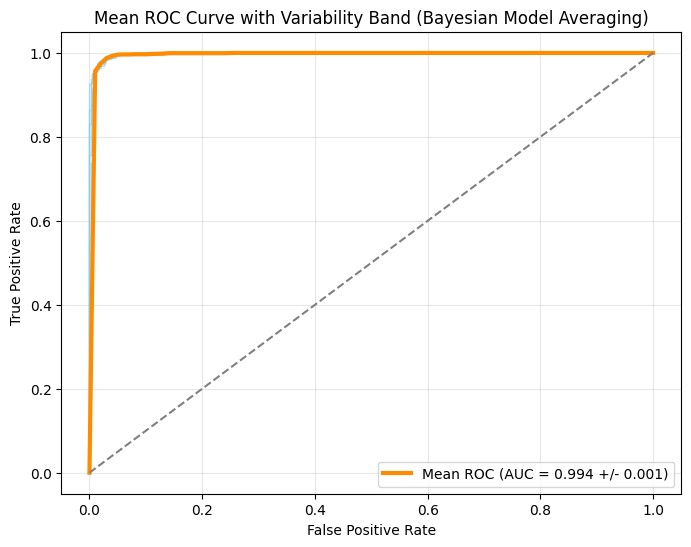

In [72]:
# Plot ROC curves for each fold and the mean ROC curve:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))

for estimator in cv_results_bma['estimator']:
    probas = estimator.predict_proba(X_full)[:, 1]
    fpr, tpr, _ = roc_curve(y, probas)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, color='skyblue')
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='darkorange',
         label=f'Mean ROC (AUC = {mean_auc:.3f} +/- {std_auc:.3f})', lw=3)
plt.fill_between(mean_fpr,
                 np.minimum(mean_tpr - np.std(tprs, axis=0), 1),
                 np.maximum(mean_tpr + np.std(tprs, axis=0), 0),
                 color='orange', alpha=0.2)

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Mean ROC Curve with Variability Band (Bayesian Model Averaging)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Final Comparison of Models

In [76]:
# Gather all results for final comparison:
baseline_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'XGBoost',
        'LightGBM',
        'SVM',
        'Random Forest',
        'Voting Classifier (Soft)',
        'Stacking Ensemble',
        'Bayesian Model Averaging'
    ],
    'Accuracy': [
        0.951, 0.949, 0.948, 0.946, 0.945,
        np.mean(cv_results_voting_soft['test_accuracy']),
        np.mean(cv_results_stacking['test_accuracy']),
        np.mean(cv_results_bma['test_accuracy'])
    ],
    'Precision': [
        0.953, 0.946, 0.940, 0.948, 0.952,
        np.mean(cv_results_voting_soft['test_precision']),
        np.mean(cv_results_stacking['test_precision']),
        np.mean(cv_results_bma['test_precision'])
    ],
    'Recall': [
        0.950, 0.953, 0.957, 0.945, 0.938,
        np.mean(cv_results_voting_soft['test_recall']),
        np.mean(cv_results_stacking['test_recall']),
        np.mean(cv_results_bma['test_recall'])
    ],
    'F1': [
        0.951, 0.949, 0.948, 0.946, 0.945,
        np.mean(cv_results_voting_soft['test_f1']),
        np.mean(cv_results_stacking['test_f1']),
        np.mean(cv_results_bma['test_f1'])
    ],
    'ROC_AUC': [
        0.991, 0.988, 0.988, 0.988, 0.985,
        np.mean(cv_results_voting_soft['test_roc_auc']),
        np.mean(cv_results_stacking['test_roc_auc']),
        np.mean(cv_results_bma['test_roc_auc'])
    ]
}).round(3)

# Rank first by accuracy, then recall:
final_comparison = baseline_results.sort_values(
    by=['Accuracy', 'Recall'], 
    ascending=False
).reset_index(drop=True)
final_comparison.insert(0, 'Rank', range(1, len(final_comparison) + 1))

# Display a ranked table:
print("Final Ranking of Models (by Accuracy, then Recall):")
display(final_comparison)

Final Ranking of Models (by Accuracy, then Recall):


,Rank,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,1,Stacking Ensemble,0.951,0.951,0.952,0.951,0.990
1,2,Logistic Regression,0.951,0.953,0.950,0.951,0.991
2,3,Voting Classifier (Soft),0.950,0.953,0.948,0.950,0.990
3,4,Bayesian Model Averaging,0.950,0.953,0.948,0.950,NaN
4,5,XGBoost,0.949,0.946,0.953,0.949,0.988
5,6,LightGBM,0.948,0.940,0.957,0.948,0.988
6,7,SVM,0.946,0.948,0.945,0.946,0.988
7,8,Random Forest,0.945,0.952,0.938,0.945,0.985
